In [1]:
import numpy as np
import torch
from torch import nn
import time
import matplotlib.pyplot as plt
from ukf  import *
from torch.utils.data import Dataset, DataLoader
import pandas as pd

In [2]:
class EV_dataset(Dataset):
    def __init__(
            self,
            overall_path,
            trip_path,
            v_nums : list = [0],
            routes : list = [0]
    ):
        super(EV_dataset, self).__init__()
        self.overall_data = pd.read_csv(overall_path)
        self.trip_data = pd.read_csv(trip_path)
        self.trip_data['trip_velocity'] = self.trip_data['trip_dist'] / self.trip_data['trip_duration']

        self.dist_minmax = (self.overall_data['trip_dist'].min(), self.overall_data['trip_dist'].max())
        self.velo_minmax = (self.trip_data['trip_velocity'].min(), self.trip_data['trip_velocity'].max())
        self.load_minmax = (self.trip_data['trip_load'].min(), self.trip_data['trip_load'].max())
        self.volt_minmax = (self.overall_data['trip_v'].min(), self.overall_data['trip_v'].max())
        self.overall_data['trip_dist'] = (self.overall_data['trip_dist'] - self.dist_minmax[0]) / (self.dist_minmax[1] - self.dist_minmax[0])
        self.trip_data['trip_velocity'] = (self.trip_data['trip_velocity'] - self.velo_minmax[0]) / (self.velo_minmax[1] - self.velo_minmax[0])
        self.trip_data['trip_load'] = (self.trip_data['trip_load'] - self.load_minmax[0]) / (self.load_minmax[1] - self.load_minmax[0])
        self.overall_data['trip_v'] = (self.overall_data['trip_v'] - self.volt_minmax[0]) / (self.volt_minmax[1] - self.volt_minmax[0])

        self.v_nums = ['V' + str(i) for i in v_nums]
        self.routes = routes
        self.overall_data = self.overall_data.loc[(self.overall_data['vin'].isin(self.v_nums)) & (self.overall_data['route'].isin(self.routes))]
        self.trip_data = self.trip_data.loc[(self.trip_data['vin'].isin(self.v_nums)) & (self.trip_data['route'].isin(self.routes))]

    def normalizing_factor(self):
        print('Return (min, max) of trip_dist, trip_velocity, trip_load, trip_v')
        return [self.dist_minmax, self.velo_minmax, self.load_minmax, self.volt_minmax]


    def __len__(self):
        return self.overall_data.shape[0]
    
    def __getitem__(self, idx):
        x = self.overall_data.iloc[idx]
        v_num = x['vin']
        route = x['route']
        t = self.trip_data.loc[(self.trip_data['vin'] == v_num) & (self.trip_data['route'] == route)]
        trip_velocity = t['trip_velocity'].item()
        trip_dist = x['trip_dist'].item()
        trip_load = t['trip_load'].item()
        target_voltage = np.expand_dims(np.array(x['trip_v'].item(), dtype=np.float32), axis=0)
        return np.array([trip_velocity, trip_dist, trip_load], dtype=np.float32), target_voltage
    

overall_path = 'C:/Users/user/project/generate_ev_data/data/overall_pd.csv'
trip_path = 'C:/Users/user/project/generate_ev_data/data/trip_pd.csv'
v_nums = [i for i in range(100)]
routes = [0]

ev_dataset = EV_dataset(overall_path, trip_path, v_nums, routes)
print(len(ev_dataset))

23595


In [3]:
def get_f(name: str = "tanh") -> nn.Module:
    activations = nn.ModuleDict(
        [
            ["lrelu", nn.LeakyReLU(0.1)],
            ["relu", nn.ReLU()],
            ["tanh", nn.Tanh()],
        ]
    )
    return activations[name]

def dense_block(layers : list(), activation: str) -> nn.Sequential:
    out = list()
    for idx, (in_f, out_f) in enumerate(zip(layers, layers[1:])):
        if idx == len(layers) - 2:
            out.append(nn.Linear(in_f, out_f, bias=False))
        else:
            out.append(nn.Linear(in_f, out_f))
            if activation is not None:
                out.append(get_f(activation))
    return nn.Sequential(*out)

class neural_network(nn.Module):
    def __init__(
            self,
            layers = None,
            input_dim = 1025, 
            hidden_dim = 1000, 
            output_dim = 1025, 
            n_layers = 8,
            activation = 'relu'
            ):
        super(neural_network, self).__init__()
        self.layers = [input_dim] + [hidden_dim] * n_layers + [output_dim]
        if layers:
            self.layers = layers
        self.net = dense_block(self.layers, activation)

    def forward(self, x):
        
        return self.net(x)

In [4]:
model = neural_network(input_dim=3, hidden_dim=8, output_dim=1, n_layers=5, activation='relu', layers=[3, 4, 8, 16, 8, 4, 1])
loss = torch.nn.functional.l1_loss

In [5]:
checkpoint = torch.load('initial_model.pt')
print(checkpoint.keys())

dict_keys(['epoch', 'model_state_dict', 'optimizer_state_dict', 'loss'])


In [6]:
model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
loss = checkpoint['loss']
epoch = checkpoint['epoch']

In [7]:
v0_model = deepcopy(model)

v_nums = [0]

loss_hist = [[], [], [], []]

v0_model.eval()
model.eval()

for route_num in range(1, 100):
    routes = [route_num]
    ev_dataset = EV_dataset(overall_path, trip_path, v_nums, routes)
    train_loader = DataLoader(ev_dataset, batch_size=512, shuffle=False)

    l_0, l_1 = 0, 0
    for inp, tar in train_loader:
        output_ = model(inp)
        
        i_loss = loss(output_, tar)
        l_0 += i_loss.item()

        output_0 = v0_model(inp)
        v0_loss = loss(output_0, tar)
        l_1 += v0_loss.item()
    l_0 /= len(train_loader)
    l_1 /= len(train_loader)
        
    loss_hist[0].append(route_num)
    loss_hist[1].append(l_0)
    loss_hist[2].append(l_1)

    if l_1 > 0.05:
        st = time.time()
        print(f'model update at route number {route_num}, ', end=' ')
        loss_hist[3].append(route_num)

        v0_model, loss_history, ukf = model_update_ukf(model = v0_model, max_iter = 40, data_loader = train_loader, ukf_params=[1,2,0])
        print('Update complete')
        print(time.time() - st)
        l_1 = 0
        for inp, tar in train_loader:
            output = v0_model(inp)
            v0_loss = loss(output, tar)
            l_1 += v0_loss.item()
        l_1 /= len(train_loader)

        loss_hist[2][-1] = l_1


model update at route number 14,  ........................................Update complete
206.44788694381714
model update at route number 17,  ........................................Update complete
206.18511748313904
model update at route number 35,  ........................................Update complete
204.5830855369568
model update at route number 38,  ........................................Update complete
202.2717423439026
model update at route number 41,  ........................................Update complete
201.52371907234192
model update at route number 45,  ........................................Update complete
202.6120903491974
model update at route number 46,  ........................................Update complete
202.36603140830994
model update at route number 48,  ........................................Update complete
203.97432589530945
model update at route number 51,  ........................................Update complete
205.08427262306213
model update at route 

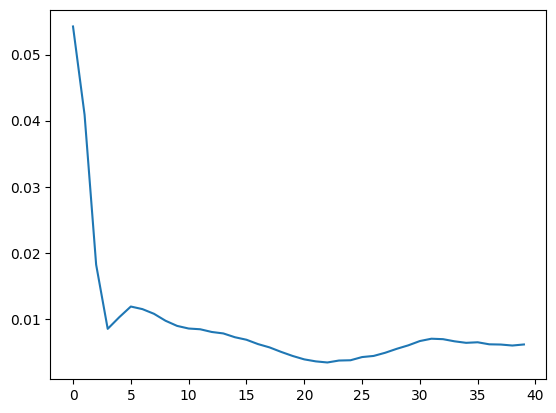

In [8]:
plt.plot(range(len(loss_history)), loss_history)
plt.show()

In [9]:
print(f'model updated {len(loss_hist[3])} times after initial model')

model updated 34 times after initial model


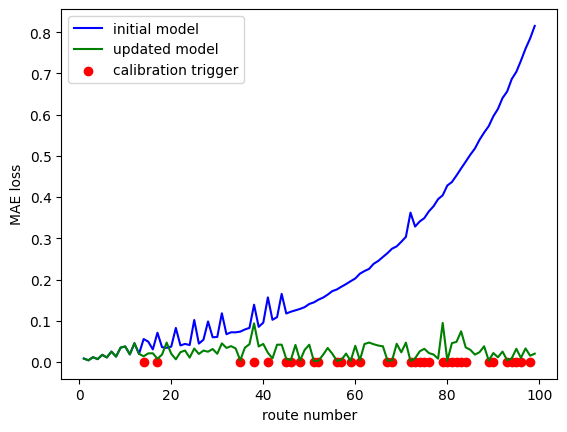

In [10]:
plt.plot(loss_hist[0], loss_hist[1], label = 'initial model', c='b')
plt.plot(loss_hist[0], loss_hist[2], label = 'updated model', c='g')
plt.scatter(loss_hist[3], [0 for _ in loss_hist[3]], label = 'calibration trigger', c='r')
plt.legend()
plt.xlabel('route number')
plt.ylabel('MAE loss')
plt.show()